<a href="https://colab.research.google.com/github/youssefhassan369/MAGIC-gamma-telescope-dataset-classification/blob/main/ai_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# Read and process Data

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


### Import data from file

In [ ]:
filename = '/content/drive/MyDrive/magic_dataset/magic04.data'
magic_df = pd.read_csv(filename) 

magic_df

,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,g
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


### Balancing data

In [ ]:
g = magic_df.groupby('g')
magic_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

### Splitting data

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(magic_df, test_size=0.3, shuffle=True)

test_data = test_df.loc[:, test_df.columns != "g"].to_numpy()
test_labels = test_df['g'].values

train_df, validation_df = train_test_split(train_df, test_size=0.1, shuffle=True)
train_data = train_df.loc[:, train_df.columns != "g"].to_numpy()
validation_data = validation_df.loc[:, train_df.columns != "g"].to_numpy()

train_labels = train_df['g'].values
validation_labels = validation_df['g'].values

# Todo split train to validation check (sklearn.model_selection)

### Scale data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform((train_data))
scaled_test_samples = scaler.fit_transform((test_data))
scaled_validation_samples = scaler.fit_transform((validation_data))

# 3. Classification

## (a) Decision Tree

### Train the model

In [ ]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier = tree_classifier.fit(scaled_train_samples, train_labels)

### Predict the test data

In [ ]:
expected_tree_labels = tree_classifier.predict(scaled_test_samples)

expected_tree_labels

array(['h', 'h', 'h', ..., 'g', 'h', 'h'], dtype=object)

## (b)  AdaBoost

### Train the model

Max n_estimator: 333, with value: 0.8295742780421692


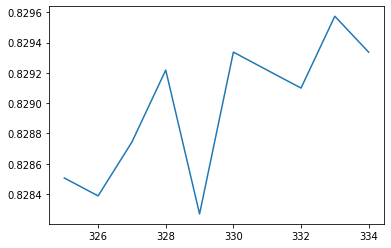

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators= list(range(325,335, 1))
est_vals = []
val = 0
max_n = -1
for est in n_estimators:
  adaboost_classifier = AdaBoostClassifier(n_estimators=est, random_state=0)
  score = cross_val_score(adaboost_classifier, scaled_train_samples, train_labels, cv=StratifiedKFold(n_splits=10)).mean()
  est_vals.append(score)
  if score > val:
    val = score
    max_n = est

plt.plot(n_estimators, est_vals)
print(f"Max n_estimator: {max_n}, with value: {val}")



### Predict the test data

In [ ]:
tuned_adaboost_classifier = AdaBoostClassifier(n_estimators=max_n, random_state=0)
tuned_adaboost_classifier.fit(scaled_train_samples, train_labels)
expected_adaboost_labels = tuned_adaboost_classifier.predict(scaled_test_samples)

expected_adaboost_labels

array(['h', 'h', 'g', ..., 'g', 'h', 'h'], dtype=object)

## (c) K-NN

### Train the data

Max n_estimator: 23, with value: 0.8182999298399845


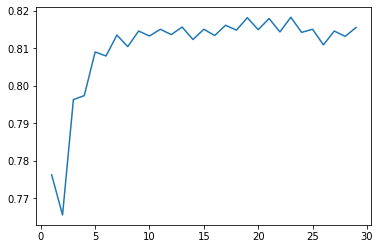

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

possible_ks = list(range(1,30, 1))
est_vals = []
val = 0
max_n_knn = -1
for k in possible_ks:
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(knn_classifier, scaled_train_samples, train_labels, cv=StratifiedKFold(n_splits=10)).mean()
  est_vals.append(score)
  if score > val:
    val = score
    max_n_knn = k

plt.plot(possible_ks, est_vals)
print(f"Max n_estimator: {max_n_knn}, with value: {val}")

### Predict the data

In [ ]:
tuned_knn_classifier = KNeighborsClassifier(n_neighbors=max_n_knn)
tuned_knn_classifier = tuned_knn_classifier.fit(scaled_train_samples, train_labels)

expected_knn_labels = tuned_knn_classifier.predict(scaled_test_samples)

expected_knn_labels

array(['h', 'g', 'g', ..., 'g', 'h', 'h'], dtype=object)

# (d) Random Forest

Max n_estimator: 191, with value: 0.8603121134507175


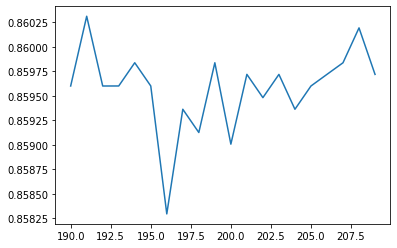

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
#initial interval was 1:250:step=20
n_estimators= list(range(190,210, 1))
est_vals = []
val = 0
max_n = -1
for est in n_estimators:
  RandomForest_classifier = RandomForestClassifier(n_estimators=est, random_state=0)
  score = cross_val_score(RandomForest_classifier, scaled_train_samples, train_labels, cv=StratifiedKFold(n_splits=10)).mean()
  est_vals.append(score)
  if score > val:
    val = score
    max_n = est
plt.plot(n_estimators, est_vals)
print(f"Max n_estimator: {max_n}, with value: {val}")

Training the model

In [ ]:
RandomForest_classifier = RandomForestClassifier(n_estimators = max_n) 
RandomForest_classifier.fit(scaled_train_samples, train_labels)

RandomForestClassifier(n_estimators=191)

Testing the model

In [ ]:
expected_random_forest_labels = RandomForest_classifier.predict(scaled_test_samples)
expected_random_forest_labels

array(['h', 'h', 'g', ..., 'g', 'h', 'h'], dtype=object)

## (e) Naive Bayes

### Training the model

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb = gnb.fit(scaled_train_samples, train_labels)

### Testing the model

In [ ]:
expected_gnb_labels = gnb.predict(scaled_test_samples)

expected_gnb_labels

array(['h', 'g', 'g', ..., 'g', 'h', 'h'], dtype='<U1')

# 5. Report Requirements

TO BE CONTINUED :: THIS IS ONLY A PLACEHOLDER

In [ ]:
def calc_accuracy(true_labels, expected_labels):
  size = len(true_labels)
  count = 0
  for i in range(size):
    if true_labels[i] == expected_labels[i]:
      count += 1
  
  return count / size

In [ ]:
def generate_confusion_matrix(true_labels,predicted_labels):
  tp=0
  tn=0
  fp=0
  fn=0
  for i in range(len(true_labels)):
    if true_labels[i]==predicted_labels[i]:
      if predicted_labels[i]=='g':
        tp+=1
      else:
        tn+=1
    else:
      if predicted_labels[i]=='g':
        fp+=1
      else:
        fn+=1
  
  return tp,tn,fp,fn

In [ ]:
def generate_report(true_labels, predicted_labels):
  tp, tn, fp , fn= generate_confusion_matrix(true_labels,predicted_labels)

  accuracy = (tp + tn) / (tp + fp + fn + tn)
  percision = tp / (tp + fp)
  recall = tp / (tp + fn)
  spcificity = tn / (tn + fp)
  f_score = 2 * (percision * recall) / (percision + recall)

  return {
      "accuracy": accuracy,
      "percision": percision,
      "recall": recall,
      "spcificity": spcificity,
      "f_score": f_score
  }

In [ ]:
tree_report = generate_report(test_labels ,expected_tree_labels)
adaboost_report = generate_report(test_labels ,expected_adaboost_labels)
random_forest_report = generate_report(test_labels ,expected_random_forest_labels)
knn_report = generate_report(test_labels ,expected_knn_labels)
naive_bayes_report = generate_report(test_labels ,expected_gnb_labels)

reports = {"Decision Tree": tree_report,  "Adaboost": adaboost_report, "Random Forest" :random_forest_report,"KNN" : knn_report , "Naive Bayes": naive_bayes_report}

  

metric: accuracy
Decision Tree: 0.7027161724395714
Adaboost: 0.7994019436830302
Random Forest: 0.8091203588337902
KNN: 0.8091203588337902
Naive Bayes: 0.6463992025915773
-------------------------------------
metric: percision
Decision Tree: 0.7802631578947369
Adaboost: 0.8163265306122449
Random Forest: 0.8664756446991404
KNN: 0.8012246820536976
Naive Bayes: 0.6265157639450283
-------------------------------------
metric: recall
Decision Tree: 0.5799511002444988
Adaboost: 0.78239608801956
Random Forest: 0.7393643031784841
KNN: 0.8317848410757946
Naive Bayes: 0.7579462102689487
-------------------------------------
metric: spcificity
Decision Tree: 0.8302845528455285
Adaboost: 0.8170731707317073
Random Forest: 0.8816056910569106
KNN: 0.7855691056910569
Naive Bayes: 0.5304878048780488
-------------------------------------
metric: f_score
Decision Tree: 0.6653576437587657
Adaboost: 0.7990012484394508
Random Forest: 0.7978891820580476
KNN: 0.8162188099808062
Naive Bayes: 0.6859924762115512


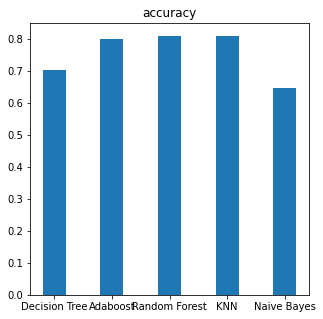

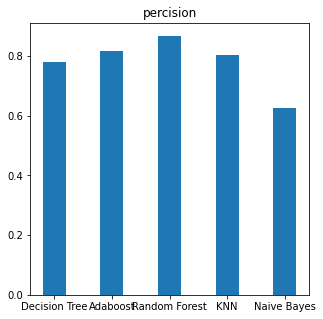

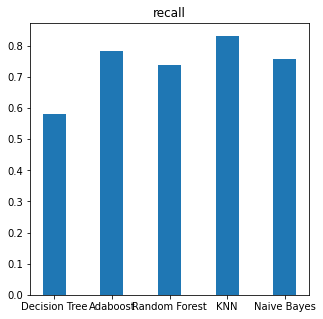

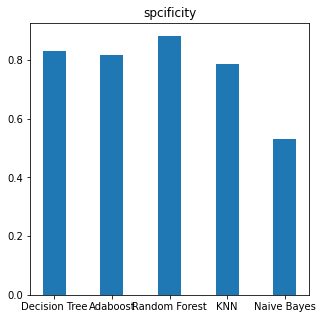

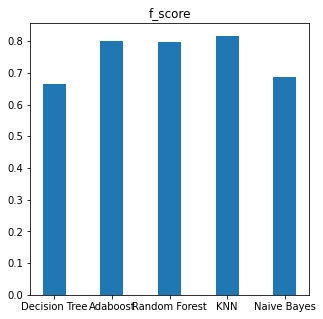

In [ ]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "percision", "recall", "spcificity","f_score"]
reports_names = ["Decision Tree", "Adaboost", "Random Forest", "KNN", "Naive Bayes"]
for metric in metrics:
  print(f"metric: {metric}")

  fig, ax = plt.subplots(figsize=(5,5))
  ax.set_title(metric)

  vals = []
  for report_item in reports.items():
    title = report_item[0]
    metric_val = report_item[1][metric]
    print(f"{title}: {metric_val}")
    vals.append(metric_val)
  print('-------------------------------------')
  plt.bar(reports_names, vals,width = 0.4)


# 6. Bonus

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import adam_v2
from keras.metrics import categorical_crossentropy

In [ ]:
from inspect import Parameter

model = Sequential([
     Dense(512, input_shape=(10,), activation='relu'),
     Dense(64,  activation='relu'), 
     Dense(2,  activation='softmax'),  
])

In [ ]:
model.compile(adam_v2.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_labels_numerical = []

for num in train_labels:
  if num == 'g':
    train_labels_numerical.append(0)
  else:
    train_labels_numerical.append(1)


train_labels_numerical = np.array(train_labels_numerical)
print(train_labels_numerical.shape)

(8426,)


In [ ]:
model.fit(scaled_train_samples, train_labels_numerical,validation_split =0.1,  batch_size = 10, epochs = 50, shuffle = True, verbose = 2)

Epoch 1/50
759/759 - 2s - loss: 0.5493 - accuracy: 0.7531 - val_loss: 0.4960 - val_accuracy: 0.7604 - 2s/epoch - 3ms/step
Epoch 2/50
759/759 - 1s - loss: 0.4740 - accuracy: 0.7769 - val_loss: 0.4607 - val_accuracy: 0.7758 - 1s/epoch - 2ms/step
Epoch 3/50
759/759 - 1s - loss: 0.4491 - accuracy: 0.7835 - val_loss: 0.4383 - val_accuracy: 0.8007 - 1s/epoch - 2ms/step
Epoch 4/50
759/759 - 1s - loss: 0.4350 - accuracy: 0.7970 - val_loss: 0.4305 - val_accuracy: 0.7900 - 1s/epoch - 2ms/step
Epoch 5/50
759/759 - 1s - loss: 0.4266 - accuracy: 0.8025 - val_loss: 0.4158 - val_accuracy: 0.8078 - 1s/epoch - 2ms/step
Epoch 6/50
759/759 - 1s - loss: 0.4208 - accuracy: 0.8059 - val_loss: 0.4073 - val_accuracy: 0.8114 - 1s/epoch - 2ms/step
Epoch 7/50
759/759 - 1s - loss: 0.4144 - accuracy: 0.8106 - val_loss: 0.4031 - val_accuracy: 0.8161 - 1s/epoch - 2ms/step
Epoch 8/50
759/759 - 1s - loss: 0.4114 - accuracy: 0.8106 - val_loss: 0.3965 - val_accuracy: 0.8161 - 1s/epoch - 2ms/step
Epoch 9/50
759/759 - 1s 

In [ ]:
predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)

In [ ]:

expected_nerual_labels= []

for p in predictions:
  if p[0] > p[1]:
    expected_nerual_labels.append(0)
  else:
    expected_nerual_labels.append(1)


test_labels_numerical = []

for num in test_labels:
  if num == 'g':
    test_labels_numerical.append(0)
  else:
    test_labels_numerical.append(1)



In [ ]:
test_labels_numerical = np.array(test_labels_numerical)
test_labels_numerical.shape

test_labels.shape

(4013,)

In [ ]:
calc_accuracy(test_labels_numerical, expected_nerual_labels)

0.8400199352105656